# Heisenberg XXX model

$$ H_{\text{TFIM}} = \sum_{j=1}^{L}(X_jX_{j+1}+Y_jY_{j+1}+Z_jZ_{j+1}) $$


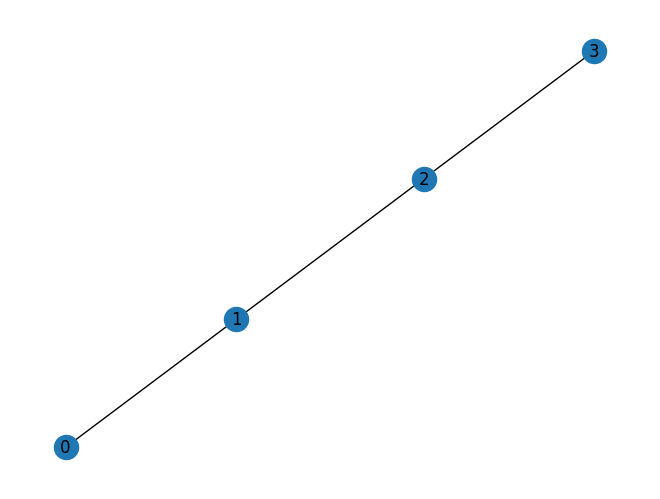

In [1]:
import networkx as nx

# Create a graph
L = 4
G = nx.Graph()
G.add_edges_from([(k,k+1) for k in range(L-1)]) 
nx.draw(G, with_labels=True)

In [2]:
from qrisp.operators import X, Y, Z

def create_heisenberg_hamiltonian(G):
    H = sum(X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) for (i,j) in G.edges())
    return H

H = create_heisenberg_hamiltonian(G)
#print(H)
#print(H.ground_state_energy())

def exp_H(qv, t):
    H.trotterization(method='commuting')(qv,t,5)

In [3]:
matrix = H.to_sparse_matrix()
import scipy
scipy.sparse.linalg.eigs(matrix)

(array([-6.46410162+5.80855133e-17j, -3.82842712+7.39080209e-17j,
        -3.82842712-5.54992398e-17j, -3.82842712-1.17782983e-16j,
         3.        +3.48994515e-17j,  3.        -7.15749147e-17j]),
 array([[ 1.10518885e-16+1.69515351e-19j, -5.22383215e-17-1.59998280e-19j,
          5.71713982e-17+3.95250168e-17j, -2.90423378e-17-1.50712298e-17j,
         -1.75374392e-01+1.23990011e-01j,  5.94922848e-01-6.33885842e-01j],
        [-8.41220841e-17-1.41808419e-16j,  1.03208987e-02-4.79307784e-02j,
         -9.47211939e-02-7.12016906e-02j, -1.73443347e-01-1.65456974e-01j,
          1.47071976e-01+4.93713311e-02j,  2.33777443e-01-5.91804665e-03j],
        [-4.03749984e-17-1.68037473e-16j, -2.49168537e-02+1.15715135e-01j,
          2.28677191e-01+1.71896087e-01j,  4.18729280e-01+3.99448470e-01j,
          1.47071976e-01+4.93713311e-02j,  2.33777443e-01-5.91804665e-03j],
        [ 2.91731052e-02+1.46553844e-01j, -1.05797696e-01-8.99798693e-02j,
          1.03933855e-01-1.78686659e-01j, -3.72

In [4]:
from qrisp import QuantumVariable   
from qrisp.vqe.problems.heisenberg import create_heisenberg_init_function

M = nx.maximal_matching(G)
U_0 = create_heisenberg_init_function(M)

qv = QuantumVariable(L)
U_0(qv)
E_0 = H.get_measurement(qv)
print(E_0)

-5.994250634555221                                                                   


In [5]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 4
s_values = np.linspace(.01,0.3,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]
circuits_gc = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='GC')
    qc = qv.qs.compile()
    circuits_gc.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-5.994250634555221, -6.240160579928859, -6.376116229757447, -6.426931204524688, -6.453713642141942]


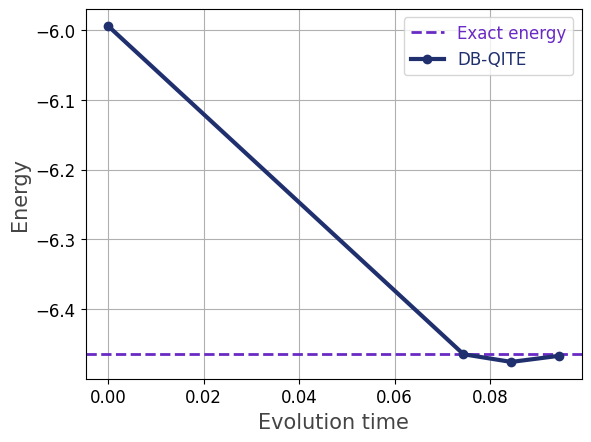

In [12]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

In [7]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 3
s_values = np.linspace(.01,0.3,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]
circuits_hopf = []

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(L)
    QITE(qv, U_0, exp_H, optimal_s, k, method='HOPF')
    qc = qv.qs.compile()
    circuits_hopf.append(qc)

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,precision=0.01,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting') for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-5.994250634555221, -6.464386863293859, -6.475389459408846, -6.466655018873559]     


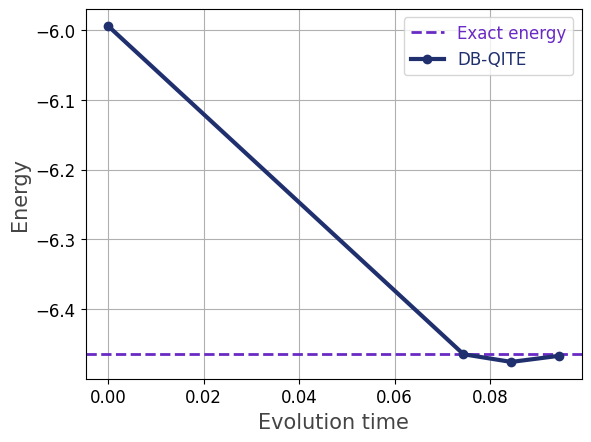

In [8]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

In [10]:
circuits_gc[0].count_ops()

{'x': 12,
 'h': 170,
 'cx': 66,
 'cz': 60,
 'rz': 90,
 'uncompiled_gidney_mcx': 3,
 'p': 1,
 'uncompiled_gidney_mcx_inv': 3}

In [11]:
circuits_gc[0].transpile().count_ops()

{'x': 28,
 'h': 170,
 'cx': 84,
 'cz': 60,
 'rz': 90,
 'sx': 6,
 't': 12,
 't_dg': 12,
 'sx_dg': 6,
 'p': 1}